<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Пропуски" data-toc-modified-id="Пропуски-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Пропуски</a></span></li><li><span><a href="#Посмотрим-на-данные-поколоночно" data-toc-modified-id="Посмотрим-на-данные-поколоночно-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Посмотрим на данные поколоночно</a></span></li><li><span><a href="#Категориальные-типы" data-toc-modified-id="Категориальные-типы-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Категориальные типы</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [238]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tqdm.contrib.itertools import product

In [239]:
pd.options.display.float_format = '{:,.2f}'.format

In [240]:
def read_file(name: str):
    # try open local file first then — if failed — open on server
    try:
        return pd.read_csv(f'./datasets/{name}', sep=',')
    except FileNotFoundError:
        try:
            return pd.read_csv(f'/datasets/{name}', sep=',')
        except Exception as e:
            print('Не удалось считать файл с данными на сервере', e, sep='\n')
            return None

    except Exception as e:
        print('Не удалось считать файл с данными на диске', e, sep='\n')
    return None

In [241]:
df = read_file('Churn.csv')

Посмотрим на случайные 7 записей в таблице

In [242]:
df.sample(n=7, random_state=1)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9953,9954,15655952,Burke,550,France,Male,47,2.00,0.00,2,1,1,"97,057.28",0
3850,3851,15775293,Stephenson,680,France,Male,34,3.00,"143,292.95",1,1,0,"66,526.01",0
4962,4963,15665088,Gordon,531,France,Female,42,2.00,0.00,2,0,1,"90,537.47",0
3886,3887,15720941,Tien,710,Germany,Male,34,8.00,"147,833.30",2,0,1,"1,561.58",0
5437,5438,15733476,Gonzalez,543,Germany,Male,30,6.00,"73,481.05",1,1,1,"176,692.65",0
8517,8518,15671800,Robinson,688,France,Male,20,8.00,"137,624.40",2,1,1,"197,582.79",0
2041,2042,15709846,Yeh,840,France,Female,39,1.00,"94,968.97",1,1,0,"84,487.62",0


Индекс в `RowNumber`, выпилим:

In [243]:
df = df.drop('RowNumber', axis=1)

`CustomerId` намекает, что все записи уникальны, проверим:

In [244]:
df['CustomerId'].value_counts(ascending=False).head()

15634602    1
15667932    1
15766185    1
15667632    1
15599024    1
Name: CustomerId, dtype: int64

Ага, id можно удалить, плюс, фамилия нам явно тоже не пригодится:

In [245]:
df = df.drop(['CustomerId', 'Surname'], axis=1)

Глянем, какие колонки остались:

In [246]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

Переименуем для удобства:

In [247]:
df.columns = [
    'credit_score', 'country', 'gender', 'age', 'years_as_client', 'balance',
    'products_count', 'has_credit_card', 'is_active_member', 'salary_estimate',
    'is_gone']

### Пропуски

In [248]:
missing_df = pd.DataFrame(
    {
        'Количество пропусков': df.isna().sum(),
        '% пропусков': df.isna().mean() * 100
    })

(missing_df[missing_df[missing_df.columns[0]] > 0]
 .sort_values(by=missing_df.columns[0]))

,Количество пропусков,% пропусков
years_as_client,909,9.09


Не будем пытаться угадать, сколько человек является клиентом: это явно
немаловажный фактор ухода (чем дольше, тем, скорее всего, меньше вероятность).

Удалим пропуски:

In [249]:
df = df.dropna()

### Посмотрим на данные поколоночно

In [250]:
df.describe(include='all')

,credit_score,country,gender,age,years_as_client,balance,products_count,has_credit_card,is_active_member,salary_estimate,is_gone
count,"9,091.00",9091,9091,"9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00"
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4550,4974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.74,NaN,NaN,38.95,5.00,"76,522.74",1.53,0.70,0.52,"100,181.21",0.20
std,96.41,NaN,NaN,10.56,2.89,"62,329.53",0.58,0.46,0.50,"57,624.76",0.40
min,350.00,NaN,NaN,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,584.00,NaN,NaN,32.00,2.00,0.00,1.00,0.00,0.00,"51,227.74",0.00
50%,652.00,NaN,NaN,37.00,5.00,"97,318.25",1.00,1.00,1.00,"100,240.20",0.00
75%,717.00,NaN,NaN,44.00,7.00,"127,561.89",2.00,1.00,1.00,"149,567.21",0.00


Визуально, вроде, все ок (нет отрицательных, максимальные числа разумные, и т. д.)

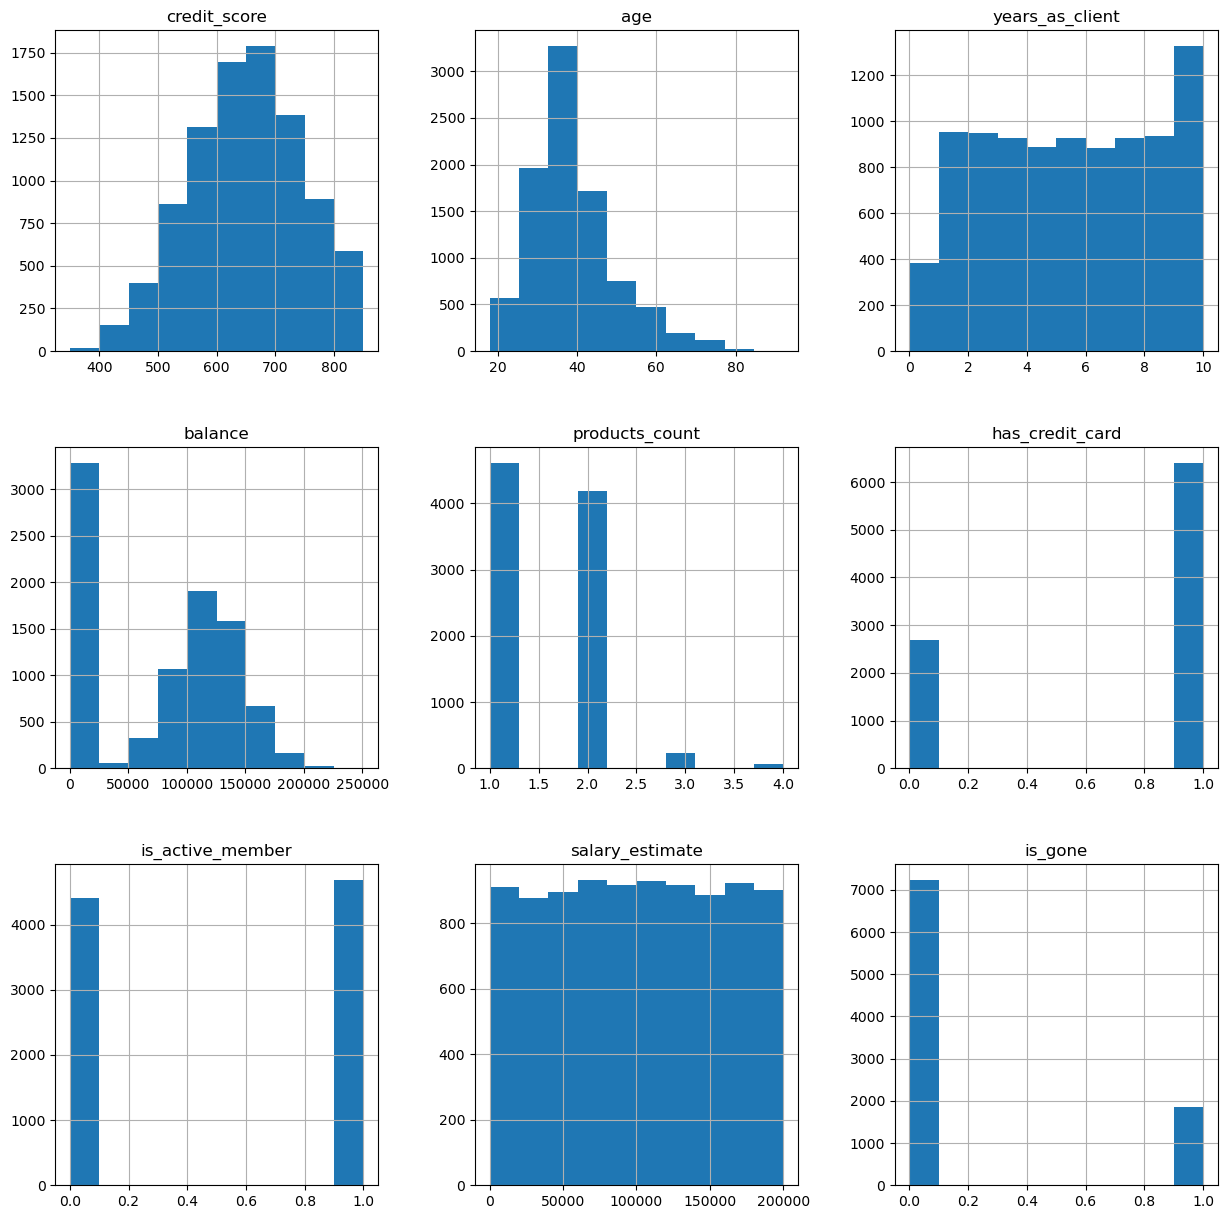

In [251]:
df.hist(figsize=(15, 15));

Видно множество числовых признаков с разным масштабом. Посмотрим на типы

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   country           9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   years_as_client   9091 non-null   float64
 5   balance           9091 non-null   float64
 6   products_count    9091 non-null   int64  
 7   has_credit_card   9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   salary_estimate   9091 non-null   float64
 10  is_gone           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


Странно, что срок клиента дробное:

In [253]:
df['years_as_client'].value_counts()

1.00     952
2.00     950
8.00     933
3.00     928
5.00     927
7.00     925
4.00     885
9.00     882
6.00     881
10.00    446
0.00     382
Name: years_as_client, dtype: int64

Поменяем тип на целый

In [254]:
df['years_as_client'] = df['years_as_client'].astype('int')

### Категориальные типы

In [255]:
df['country'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: country, dtype: int64

In [256]:
df['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

Преобразуем для дальнейшего обучения

In [257]:
df = pd.get_dummies(df, drop_first=True)

In [258]:
df.head()

,credit_score,age,years_as_client,balance,products_count,has_credit_card,is_active_member,salary_estimate,is_gone,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,"101,348.88",1,0,0,0
1,608,41,1,"83,807.86",1,0,1,"112,542.58",0,0,1,0
2,502,42,8,"159,660.80",3,1,0,"113,931.57",1,0,0,0
3,699,39,1,0.00,2,0,0,"93,826.63",0,0,0,0
4,850,43,2,"125,510.82",1,1,1,"79,084.10",0,0,1,0


### Разбивка данных

In [259]:
target = df['is_gone']
features = df.drop('is_gone', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, stratify=target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, stratify=target_train, test_size=0.25, random_state=12345)

### Масштабирование данных

In [260]:
numeric_columns = [
    'credit_score', 'age', 'years_as_client', 'balance', 'products_count',
    'salary_estimate']

In [261]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

### Корреляции

Посмотрим, на всякий случай, на корреляции между признаками:

In [262]:
corr = features.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,credit_score,age,years_as_client,balance,products_count,has_credit_card,is_active_member,salary_estimate,country_Germany,country_Spain,gender_Male
credit_score,1.00,-0.00,-0.00,0.00,0.01,-0.00,0.03,0.01,0.00,0.00,-0.01
age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.08,-0.01,0.05,-0.01,-0.03
years_as_client,-0.00,-0.01,1.00,-0.01,0.01,0.03,-0.03,0.01,-0.00,0.00,0.01
balance,0.00,0.03,-0.01,1.00,-0.30,-0.02,-0.00,0.01,0.40,-0.14,0.02
products_count,0.01,-0.03,0.01,-0.30,1.00,0.01,0.01,0.01,-0.01,0.01,-0.03
has_credit_card,-0.00,-0.01,0.03,-0.02,0.01,1.00,-0.01,-0.01,0.01,-0.02,0.01
is_active_member,0.03,0.08,-0.03,-0.00,0.01,-0.01,1.00,-0.02,-0.02,0.01,0.03
salary_estimate,0.01,-0.01,0.01,0.01,0.01,-0.01,-0.02,1.00,0.01,-0.01,-0.00
country_Germany,0.00,0.05,-0.00,0.40,-0.01,0.01,-0.02,0.01,1.00,-0.33,-0.02
country_Spain,0.00,-0.01,0.00,-0.14,0.01,-0.02,0.01,-0.01,-0.33,1.00,0.02


Видим, что есть небольшая между 1) балансом и тем, что человек из Германии
2) балансом и количеством продуктов. В целом, ничего критичного, можно работать.

### Вывод

- несколько странно видеть ненормальное распределение для предполагаемой зарплаты;
- для около 9% записей не было информации о том, как долго они пользуются банком —
странно. Это явно достаточно важная метрика для retention, поэтому просто
удалили эти пропущенные записи, вместо того, чтобы заменить рыбой;
- в остальном, в целом, все визуально в порядке. Привели к одному масштабу
численные и преобразовали категориальные признаки.

## Исследование задачи

На графиках был виден дисбаланс в целевом признаке. Посмотрим на него еще раз

In [263]:
print(f'Доля ушедших:{target.mean():.2%}')

Доля ушедших:20.39%


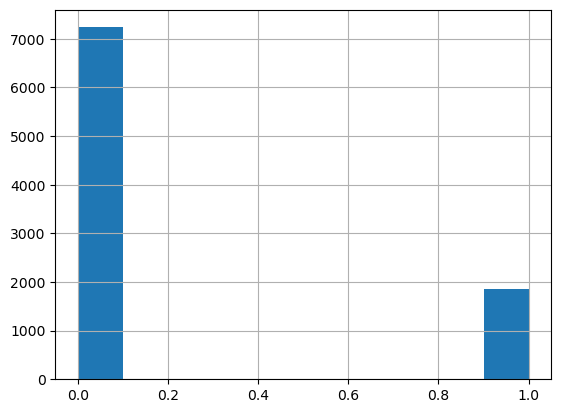

In [264]:
target.hist();

Виден дисбаланс примерно в 1:4. Попробуем пока проигнорировать этот факт

### Лес

In [265]:
def get_best_forest(is_balanced: bool):
    best_model = None

    best_f1 = 0
    best_model_auc = 0
    best_auc = 0

    for params in product(
            ['gini', 'entropy'],
            range(10, 100, 10),
            range(5, 25, 1)):
        criterion, n_estimators, max_depth = params
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            class_weight='balanced' if is_balanced else None,
            n_jobs=-1,
            random_state=12345)
        model.fit(features_train, target_train)

        f1 = f1_score(target_valid, model.predict(features_valid))

        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

        if f1 > best_f1:
            best_model = model
            best_f1 = f1
            best_model_auc = auc_roc

        if auc_roc > best_auc:
            best_auc = auc_roc

    print(f'best f1={best_f1:.3f}, best model auc={best_model_auc:.3f}, best auc={best_auc:.3f}')
    print(f'estimators={best_model.n_estimators}, criterion={best_model.criterion}, depth={best_model.max_depth}')

    return best_model

In [266]:
_ = get_best_forest(is_balanced=False)

  0%|          | 0/360 [00:00<?, ?it/s]

best f1=0.588, best model auc=0.843, best auc=0.869
estimators=20, criterion=entropy, depth=16


### Логистическая регрессия

In [267]:
def get_best_log_reg(is_balanced: bool):
    best_model = None

    best_f1 = 0
    best_model_auc = 0
    best_auc = 0

    for params in product(
            ['lbfgs', 'liblinear', 'newton-cholesky'],
            range(10, 200, 10)):
        solver, max_iter = params
        model = LogisticRegression(
            solver=solver,
            max_iter=max_iter,
            class_weight='balanced' if is_balanced else None,
            random_state=12345,
            n_jobs=None)
        model.fit(features_train, target_train);

        f1 = f1_score(target_valid, model.predict(features_valid))

        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

        if f1 > best_f1:
            best_model = model
            best_f1 = f1
            best_model_auc = auc_roc

        if auc_roc > best_auc:
            best_auc = auc_roc

    print(f'best f1={best_f1:.3f}, best model auc={best_model_auc:.3f}, best auc={best_auc:.3f}')
    print(f'solver={best_model.solver}, max_iter={best_model.max_iter}')
    return best_model

In [268]:
_ = get_best_log_reg(is_balanced=False)

  0%|          | 0/57 [00:00<?, ?it/s]

/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


best f1=0.286, best model auc=0.758, best auc=0.758
solver=lbfgs, max_iter=10


### Вывод

В 2 раза лучше f1 показал лес, но f1=0.588 не дотягивает до минимально
требуемой 0.59. Попробуем теперь сбалансировать классы

## Борьба с дисбалансом

Укажем при обучении, что классы нужно сбалансировать

In [269]:
best_forest = get_best_forest(is_balanced=True)

  0%|          | 0/360 [00:00<?, ?it/s]

best f1=0.618, best model auc=0.853, best auc=0.868
estimators=20, criterion=gini, depth=9


In [270]:
best_log_reg = get_best_log_reg(is_balanced=True)

  0%|          | 0/57 [00:00<?, ?it/s]

/Users/piskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


best f1=0.497, best model auc=0.761, best auc=0.761
solver=lbfgs, max_iter=20


### Вывод

Балансировка позволила улучшить модели и поднять лес выше необходимого порога по f1.

## Тестирование модели

In [271]:
def print_stats(model):
    f1 = f1_score(target_test, model.predict(features_test))

    probabilities_valid = model.predict_proba(features_test)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_test, probabilities_one_valid)

    print(f'f1={f1:.3f}, auc={auc_roc:.3f}')

    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

    plt.figure()

    # < постройте график >
    plt.plot(fpr, tpr)

    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')

    # < примените функции plt.xlim() и plt.ylim(), чтобы
    #   установить границы осей от 0 до 1 >
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # < примените функции plt.xlabel() и plt.ylabel(), чтобы
    #   подписать оси "False Positive Rate" и "True Positive Rate" >
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >
    plt.title("ROC-кривая")

    plt.show()

f1=0.608, auc=0.842


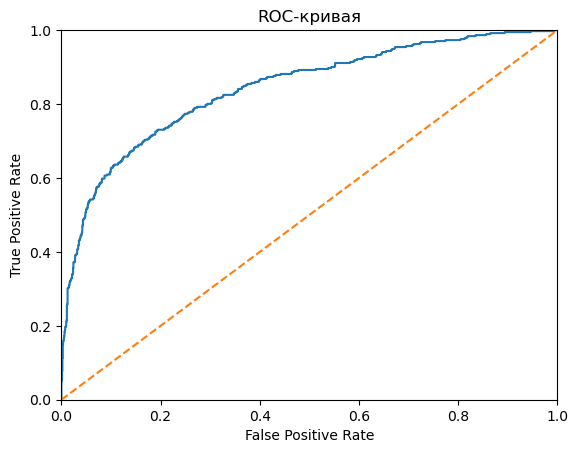

In [272]:
print_stats(best_forest)

Отлично, на тестовой выборке держим качество выше необходимого (0.608 > 0.59).

Попробуем теперь обучить с найдеными гиперпараметрами на объединенной выборке
из тестовой и валидизационной:

In [273]:
model = RandomForestClassifier(
    n_estimators=20,
    criterion='gini',
    max_depth=9,
    class_weight='balanced',
    n_jobs=-1,
    random_state=12345)

model.fit(pd.concat([features_train, features_valid], ignore_index=True),
          pd.concat([target_train, target_valid], ignore_index=True))

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=20,
                       n_jobs=-1, random_state=12345)

f1=0.627, auc=0.855


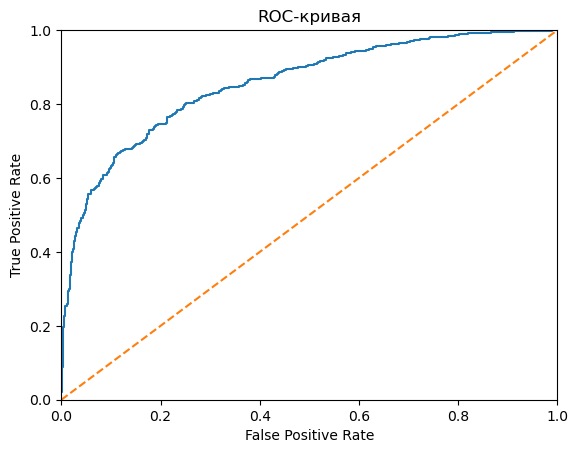

In [274]:
print_stats(model)

Вывод: качество подросло еще немного

## Общий вывод

Что помогло улучшить модель:
- стратификация при разбиении данных;
- балансировка при обучении.

Лес оказался ожидаемо лучше логистической регрессии. Поэтому, в целом, данные
можно было не масштабировать — ему это не важно.

Итоговая модель получилась с f1=0.627 и auc=0.855

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*